In [128]:
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from scipy.integrate._ivp.ivp import OdeResult # for type check in the plot function
from scipy.optimize import curve_fit

In [157]:
plt.rcParams['axes.labelsize'] = 14      # grandezza etichette assi (xlabel, ylabel)
plt.rcParams['xtick.labelsize'] = 12     # grandezza numeri asse x
plt.rcParams['ytick.labelsize'] = 12     # grandezza numeri asse y
plt.rcParams['legend.fontsize'] = 12     # grandezza testo legenda
plt.rcParams['axes.titlesize'] = 16      # grandezza titolo del grafico

In [11]:
def debug(text, debug_mode=True):
    """
    text: the text that preceed the debug message
    var: list of variables whose values are to be displayed
    """
    if debug_mode:
        print(text)

debug_flag=False

#### 1) Parametri e condizioni iniziali

In [95]:
###########################################################################
# Dati sperimetali
molecules_per_uM = 500 # molecole/uM : circa 500 molecole per avere una concentrazione molare di 1 uM


###########################################################################
#  Parameters
n = 3 # hill parameter

alpha_1 = 0.2 # uM/ min
alpha_2 = alpha_1 

beta_1 = 4 # uM/ min
beta_2 = beta_1 

K1 = 1 # uM
K2 = K1

d1_base = 1 # 1/min. Si chiama base perchè è il valore per istanti iniziali (fra 0 e 60 min). Dopodichè aumenta (vedi dopo)
d2 = d1_base

gamma = 1 # 1/min

epsilon = 1

s = 1.7  # adimensional



###########################################################################
# Initial conditions (numero di molecole!)
u_0_nmolecules = 2125 # λCI
v_0_nmolecules = 125 # LacR

def from_molecules_to_uM(molecules, molecules_per_uM):
    return molecules / molecules_per_uM

def from_uM_to_molecules(uM, molecules_per_uM):
    return uM * molecules_per_uM

# intial conditions in uM
u_0 = from_molecules_to_uM(u_0_nmolecules, molecules_per_uM)
v_0 = from_molecules_to_uM(v_0_nmolecules, molecules_per_uM)
print(f"Initial conditions: u_0 = {u_0:.2f} uM, v_0 = {v_0:.2f} uM")


###########################################################################
# MMC induction window
t_start_MMC = 60 # min
t_end_MMC = 960 # min


Initial conditions: u_0 = 4.25 uM, v_0 = 0.25 uM


**Riguardo al parametro d1:**

- d₁ è il tasso di degradazione della proteina λCI.

- Normalmente vale d₁ = 1 min⁻¹, ma quando la cellula subisce danno al DNA (indotto dalla mitomicina C, MMC) la proteina RecA si lega a λCI e ne aumenta la degradazione.

    - Prima e dopo l’induzione (t < 60 min o t > 960 min): d1 = d1_base = 1; 
    - Durante l’induzione (60 ≤ t ≤ 960 min): d1= d1_base + gamma*s / (1+s)
- Nel modello del paper la prima ora (t < 60 min) serve per far stabilizzare il sistema nello stato iniziale ad alto λCI. Invece il trattamento con MMC dura 15h, per questo dopo 960 min d1 torna al livello base

#### 2) Modello deterministico


In [96]:
def make_toggle_switch_ode(alpha_1, beta_1, alpha_2, beta_2,
                           K1, K2, d1_base, n, d2, gamma, epsilon, t_start_MMC=60, t_end_MMC=960):
    """
    Factory for build genetic switch deterministic  model

    Here we use concentrations in uM for the variables
    """

    def d1(t, s):
        if t < t_start_MMC or t > t_end_MMC:
            return d1_base # outside the MMC induction window
        else:
            return d1_base + gamma * s / (1 + s) #during the MMC induction window
    
    def hill_function(x, K):
        """
        Function to be used in the ODEs to model the Hill function.
        Args:
            x : concentration of one of the two species (u or v)
            K : a parameter that sets the threshold for the Hill function

            Note: x and K should be in the same units 
        """
        return K**n / (K**n + x**n)

    def genetic_switch_ode(t, y, s):
        u, v = y # current values. u= λCI, v = LacR
        du = ( epsilon * (alpha_1 + beta_1 * hill_function(v, K1)) ) - d1(t, s) * u
        dv = ( epsilon * (alpha_2 + beta_2 * hill_function(u, K2)) ) - d2 * v
        return [du, dv]

    return genetic_switch_ode



In [121]:
def plot_trajectories(s_values, sims, filename="fig2.svg", save_plot=True):
    """
    This function plots the evolution of the system for different s values.
    It can be used both for the deterministic system, where data is measured in uM,
    and for the stochastic system, where data is measured in number of molecules.

    Args:
        s_values: list of s values for which the simulations were run
        sims: list of simulation results, where each result corresponds to a value in s_values

        Note:
        The type of elements in sims can be either:
            - OdeResult: for deterministic results, where the solution is an object with attributes t and y
            - tuple: for stochastic results, where the first element is time, the second is the number of molecules of u, 
                     and the third is the number of molecules of v 
    """
    num_curves = len(s_values) 
    if num_curves>5: raise Exception("Too many curves. Max number with current setting is 6. If you need more, change the color list")
    # Update: safety check: number of trajectories coincide with number of s values

    # Plot curves
    plt.figure(figsize=(8,5))

    color_idx, color_list = 0, list(plt.colormaps['Paired'].colors)
    for s, sol in zip(s_values, sims):
        
        #load the solutions
        if isinstance(sol, OdeResult):  #deterministic results
            t, u, v = sol.t, sol.y[0], sol.y[1]
            ylabel = "concentrations (μM)"
            sim_type= "Deterministic"
        else: #stochastic results
            t, u, v = sol
            ylabel = "number of molecules"
            sim_type= "Stochastic"

        #plot the curves
        if num_curves > 1:
            plt.plot(t, u, color=color_list[color_idx],  label=f"s={s}, LacR ", linewidth=2, alpha=0.7)
            plt.plot(t, v, color=color_list[color_idx+1], label=f"s={s}, λCI ", linewidth=2, alpha=0.7)
            title = sim_type + f" genetic switch model for multiple s values"
            
        else:
           plt.plot(t, u, color="red",  label=f"LacR", linewidth=0.7, alpha=0.8)
           plt.plot(t, v, color="blue", label=f"λCI", linewidth=0.7, alpha=0.8)
           title = sim_type + f" genetic switch model (s={s})"

        color_idx+=2

    plt.ylabel(ylabel)
    plt.xlabel("time (min)")
    plt.axvspan(t_start_MMC, t_end_MMC, alpha=0.15, color='gray', label='MMC induction window')
    plt.legend()
    plt.tight_layout()
    plt.title(title)
    if save_plot: plt.savefig(filename, format='svg')
    plt.show()
    


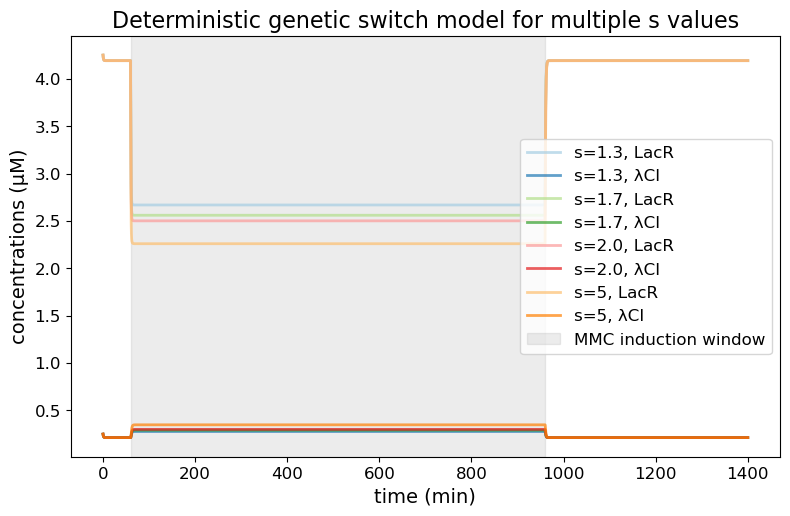

In [ ]:
ode_system = make_toggle_switch_ode(alpha_1, beta_1, alpha_2, beta_2, K1, K2, d1_base, n, d2, gamma, epsilon)

t_sim = [0, 1400] # simulation time (min)
y0 = [u_0, v_0] # initial conditions in uM
delta_t = 0.5

def run_sim(s, y0, t_sim, delta_t):
    sol = solve_ivp(lambda t, y: ode_system(t, y, s),
                    t_sim, y0, max_step=delta_t)
    return sol

# Try a few s values 
s_values = [1.3, 1.7, 2.0, 5]
sims = [run_sim(s, y0, t_sim, delta_t) for s in s_values]

plot_trajectories(s_values, sims, filename="results/fig2_deterministic_multiple_s_values.svg")

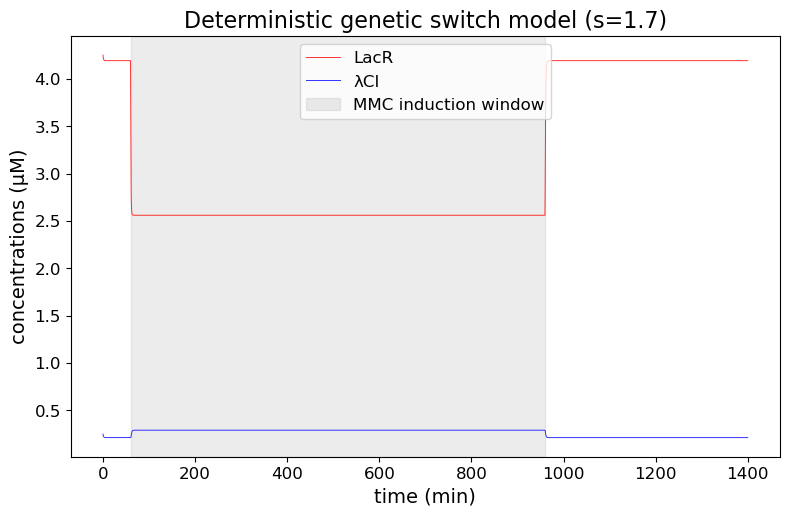

In [ ]:
s_values = [1.7]
sims = [run_sim(s, y0, t_sim, delta_t) for s in s_values]

plot_trajectories(s_values, sims, filename="results/fig2_deterministic.svg")

The deterministic model switches only for very big value of $s$!

#### 3) Modello stocastico

In [ ]:
def make_toggle_switch_stochastic(alpha_1, beta_1, alpha_2, beta_2,
                           K1, K2, d1_base, n, d2, gamma, epsilon, u_0_nmolecules, v_0_nmolecules, t_start_MMC=60, t_end_MMC=960, t_end_sim=1200):
    """
    Factory for build genetic switch stochastic (tau-leap) model
    """

    def d1(t, s):
        if t < t_start_MMC or t > t_end_MMC:
            return d1_base # outside the MMC induction window
        else:
            return d1_base + gamma * s / (1 + s) #during the MMC induction window
    
    def hill_function(x, K):
        """
        Function to be used in the ODEs to model the Hill function.
        Args:
            x : concentration of one of the two species (u or v)
            K : a parameter that sets the threshold for the Hill function

            Note: x and K should be in the same units 
        """
        return K**n / (K**n + x**n)

    def genetic_switch_stochastic(tau, s, enable_bimodal_sampling=False):
        """
        One stochastic trajectory via Poisson tau-leap for the SOS-pathway genetic switch.
        
        Two strategy are implemented to avoid negative values for the number of molecules after the updates:
        1. Bimodal sampling: using binomial distribution for the degradation step
        2. Post-leap check: if the update leads to negative values, the step is discarded and tau is divided by 2.
        You can choose which one to use by setting the enable_bimodal_sampling flag.
        
        Returns times, u, v arrays.
        """
        ### convert the parameters from concentrations to molecular numbers
        alpha_1_nmol = 500 * alpha_1
        beta_1_nmol =  500 * beta_1
        alpha_2_nmol =  500 * alpha_2
        beta_2_nmol =  500 * beta_2
        K1_nmol  =  500 * K1
        K2_nmol =  500 * K2
        debug(f"Parameters converted:\n\talpha_1_nmol:{alpha_1_nmol}, beta_1_nmol: {beta_1_nmol},\n\talpha_2_nmol: {alpha_2_nmol}, beta_2_nmol: {beta_2_nmol},\n\tK1_nmol: {K1_nmol}, K2_nmol: {K2_nmol}\n", debug_flag)
        

        ### Initializiation 
        t = [0.0] 
        u = [u_0_nmolecules]
        v = [v_0_nmolecules]
        ##  Maybe update because of slowleness of lists
        debug(f"Step 0:\n sim time 0.0 min:\nInitial nr of molecules:\n\tu: {u[0]}, v: {v[0]} \n-----------------------\n", debug_flag)
        if u[0]<0 or v[0] < 0: raise Exception("Got negative value for inital molecular number: non valid")
 
        rng = np.random.default_rng() #generatore di numeri casuali


        ### Tau-leap algorithm with post-leap check
        k=0 # simulation step index
        current_tau = tau
        tk = t[0]
        while tk < t_end_sim and current_tau > 0.01: # if t reaches the t_end_MMC or tau reaches the lower bound, exit the loop

            uk, vk = u[-1], v[-1] #previous values (needed to compute updates)

            ### propensity rates (molecules/min)
            prop_u = epsilon * (alpha_1_nmol + beta_1_nmol * hill_function(vk, K1_nmol))
            prop_v = epsilon * (alpha_2_nmol + beta_2_nmol * hill_function(uk, K2_nmol))
            debug(f"prop_u: {prop_u}, prop_v: {prop_v}",  debug_flag)
            if prop_u<0 or prop_v < 0: raise Exception("Got negative value for propensity functions: non valid as the Poisson mean must be positive")#ensure that the mean is not negative: poisson property

            ### degradation rates (molecules/min)
            deg_u = d1(tk, s) * uk #ensure number of molecules is not negative, otherwise subtracting deg_ in the updates will lead to an increase 
            deg_v = d2 * vk 
            debug(f"deg_u: {deg_u}, deg_v: {deg_v}",  debug_flag)
            if deg_u<0 or deg_v < 0: raise Exception("Got negative value for propensity functions: non valid as the Poisson mean must be positive")#ensure that the mean is not negative: poisson property


            ### Poisson jumps with mean = rate*tau for the increase
            #sampling number of molecules produced
            dU_increase = rng.poisson(prop_u * current_tau) 
            dV_increase = rng.poisson(prop_v * current_tau)
            debug(f"dU_increase: {dU_increase}, dV_increase: {dV_increase}",  debug_flag)

            # sampling number of molecules degradated 
            if enable_bimodal_sampling: #binomial strategy
                print("TODO")
            #     # Binomial jumps (degradation) starting from total propensities deg_u = d1*uk, deg_v = d2*vk
            #     if uk > 0:
            #         p_u = 1.0 - np.exp(-(deg_u / uk) * tau)   # per-molecule probability (GPT)
            #         dU_decrease = rng.binomial(int(uk), p_u)
            #     else:
            #         dU_decrease = 0

            #     if vk > 0:
            #         p_v = 1.0 - np.exp(-(deg_v / vk) * tau) # per-molecule probability (GPT)
            #         dV_decrease = rng.binomial(int(vk), p_v)
            #     else:
            #         dV_decrease = 0
            
            else: #post leap check strategy
                dU_decrease = rng.poisson(deg_u * current_tau)
                dV_decrease = rng.poisson(deg_v * current_tau)
            debug(f"dU_decrease: {dU_decrease}, dV_decrease: {dV_decrease}",  debug_flag)


            ### updates
            uk = uk + dU_increase - dU_decrease
            vk = vk + dV_increase - dV_decrease

            #Post leap check:
            if uk < 0 or vk < 0:
                debug("**************************************\nGot negative values for the updates, discarding the updates and repeating the step after dividing tau by half", True) 
                current_tau /= 2
                debug(f"Updated tau: {current_tau} min\n**************************************", True)        
        
            else: 
                tk += current_tau #update time: this is the current time of simulation

                k += 1 #update step

                #storing values
                t.append(tk) # current time of sim
                u.append(uk)
                v.append(vk)
                
                debug(f"Step {k+1}:\t\t sim time: {tk+tau} min \t\tu: {uk}, v: {vk}", debug_flag)

        if t[-1] < t_end_MMC: debug(f"Simulation failed because of threshold for tau reached.\n Time achieved: {t[-1]}")
        else: debug("Successful simulation", debug_flag)

        # Convert lists to numpy arrays for consistency
        t = np.array(t)
        u = np.array(u)
        v = np.array(v)

        return t, u, v
    
    return genetic_switch_stochastic




Riguardo la **post-leap check strategy**:


Con il tau-leap “puro” può capitare che le reazioni di degradazione sottraggano più molecole di quante ce ne sono a disposizione, portando a valori negativi. Una delle strategie standard usate nella pratica per evitarlo è il *Post-leap check + riduzione adattiva di τ*:

- Fai il leap;
- Se $u_{k+1}<0$ o $v_{k+1}<0$ annulla quello step, dimezza τ e riesegui il campionamento. Ripeti finché non hai aggiornamenti validi (o fino a un minimo τ).

Simulation 1


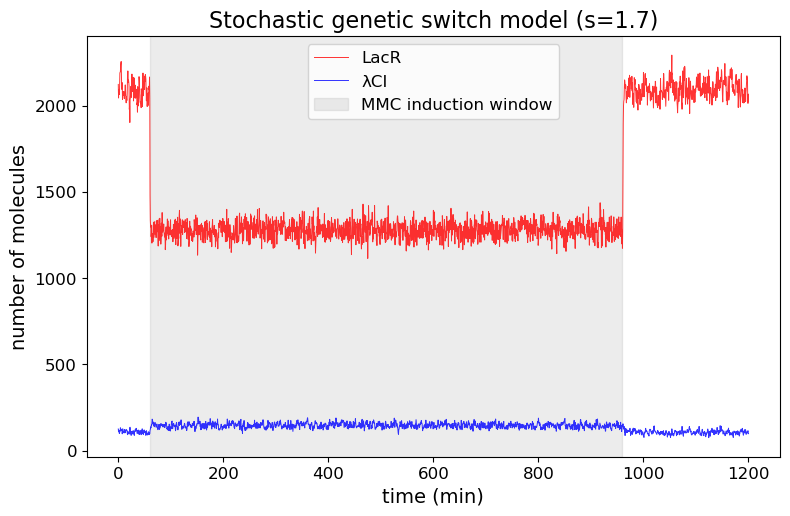

Simulation 2


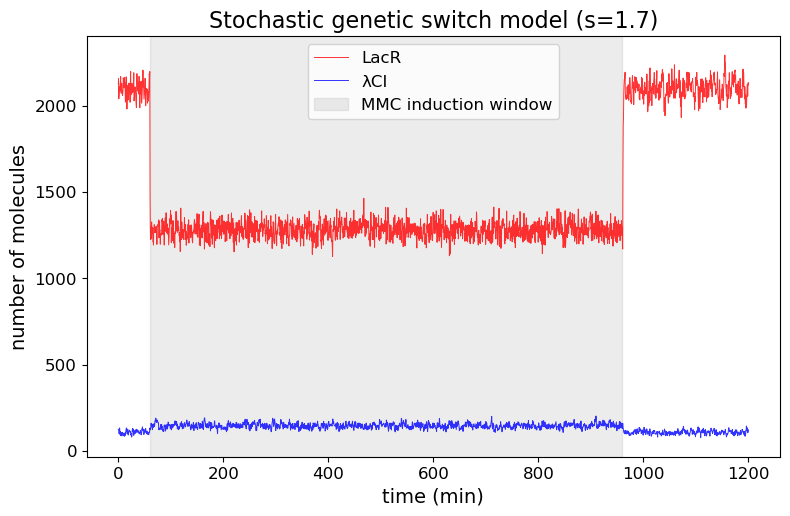

Simulation 3


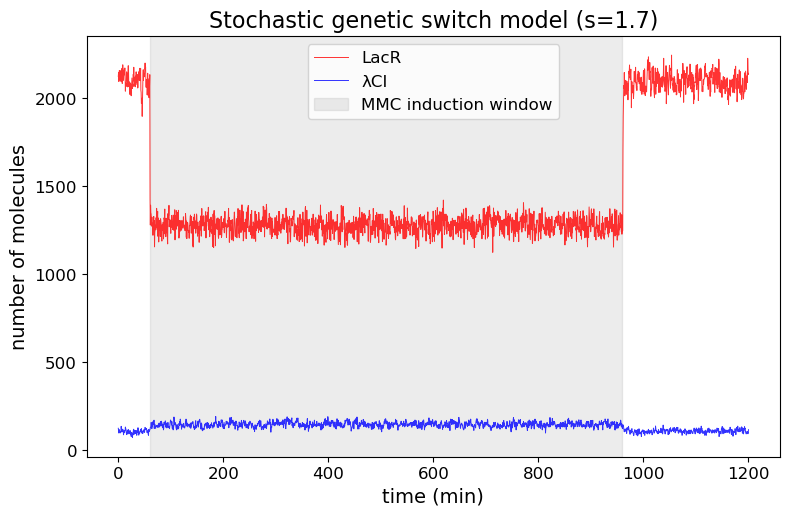

Simulation 4


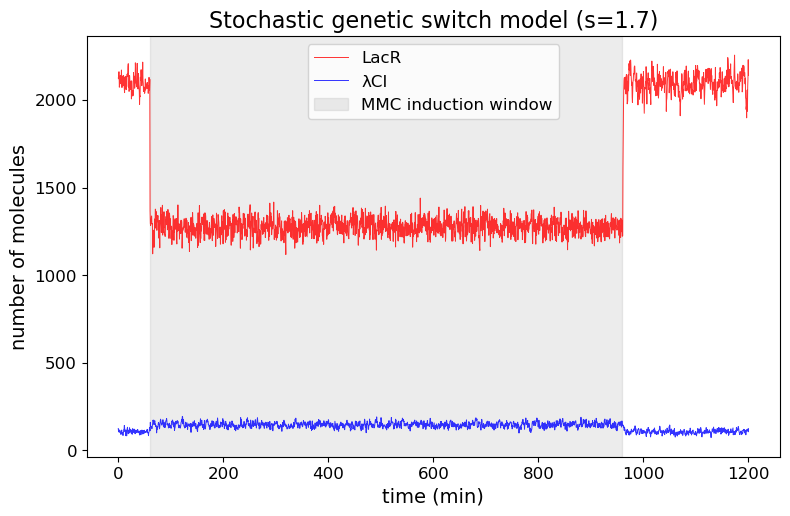

Simulation 5


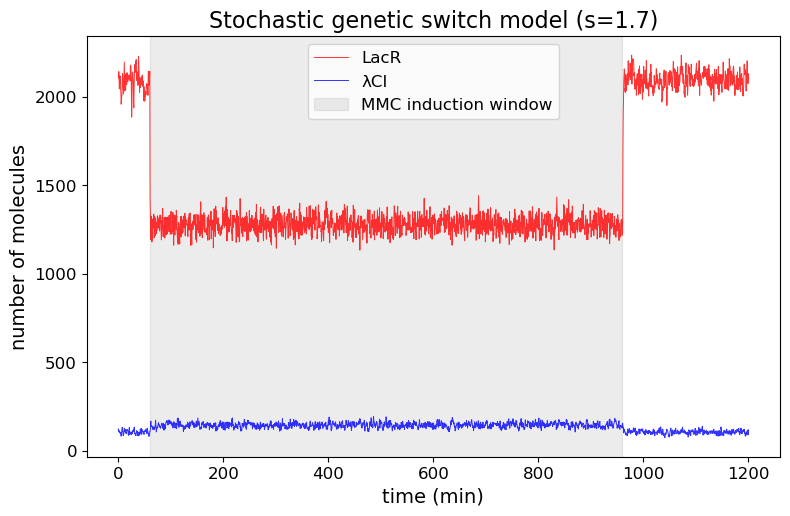

Simulation 6


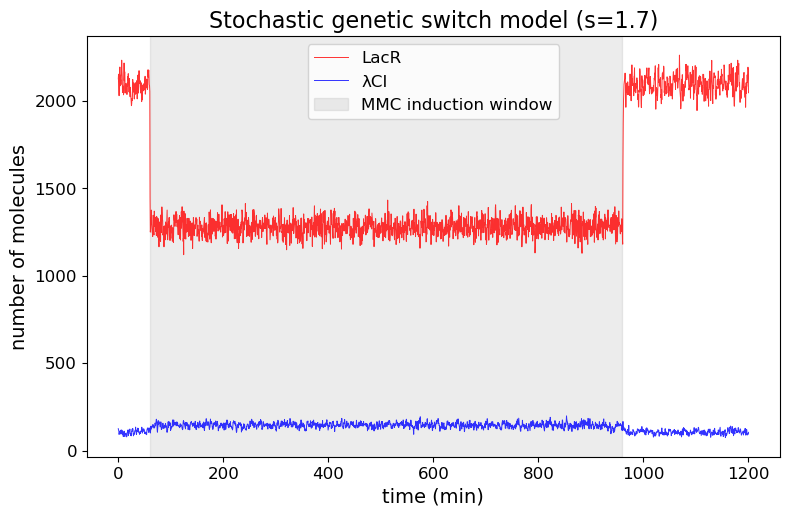

Simulation 7


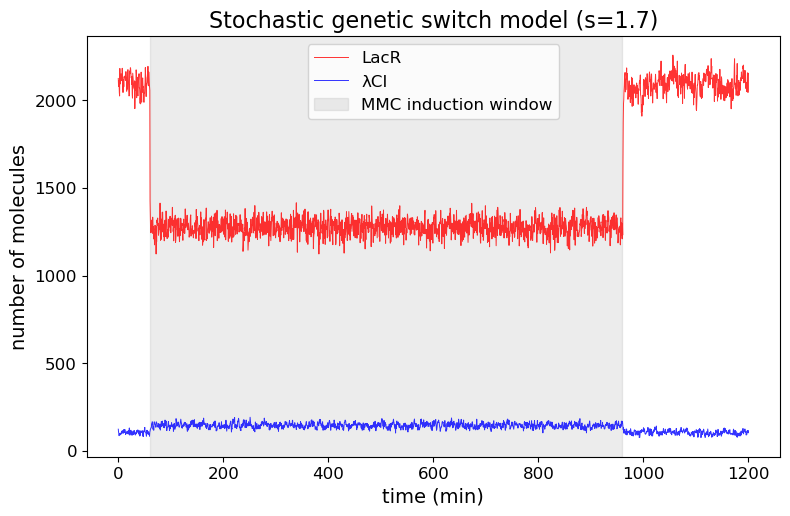

Simulation 8


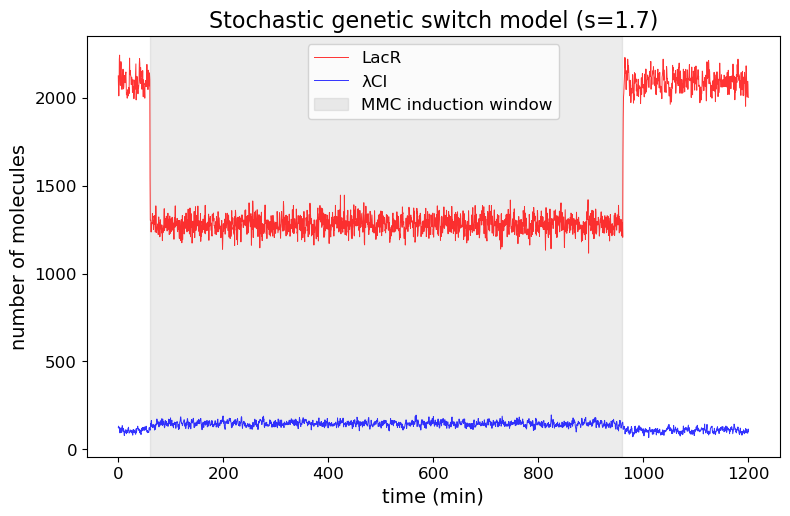

Simulation 9


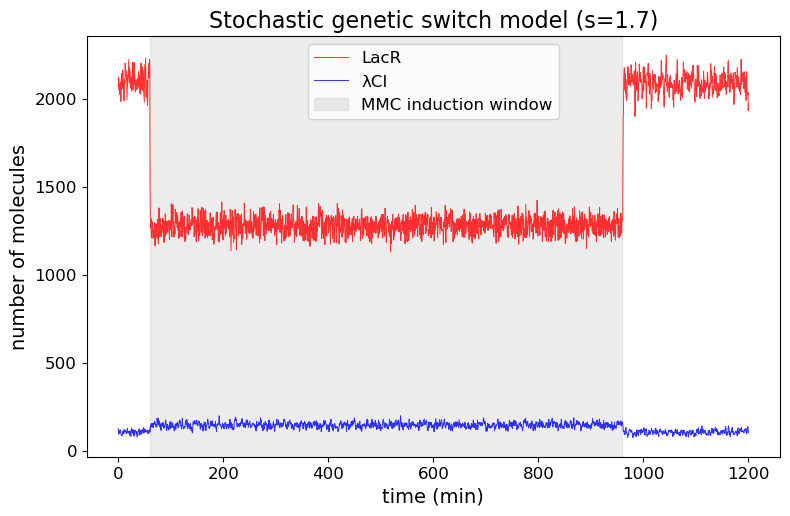

Simulation 10


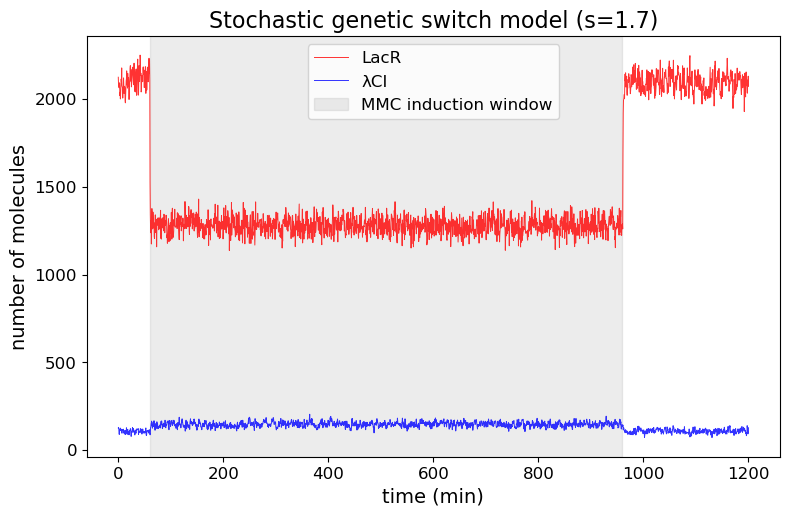

In [ ]:
stochastic_model = make_toggle_switch_stochastic(alpha_1, beta_1, alpha_2, beta_2, K1, K2, 
                                                 d1_base, n, d2, gamma, epsilon, u_0_nmolecules, v_0_nmolecules)

# Try a few s values around the reported threshold range
s_values = [1.7]
tau = 0.5

# Running multiple simulations with the same initial conditions and parameters
# to see the variability of the results due to the stochastic nature of the model
N_trials = 10
for i in range(N_trials):
    print(f"Simulation {i+1}")
    sims = [stochastic_model(tau, s) for s in s_values]
    plot_trajectories(s_values, sims, filename=f"results/fig2_stochastic_trial_{i+1}.svg")



Nel caso stocastico si ottiene lo switch anche con valori di s più piccoli (rispetto al caso deterministico). Inoltre lo switch può avvenire o meno con la stessa configurazione dei parametri iniziali!

#### 3.1) Istogramma LacR al variare di s (Fig 3)

In [125]:
def check_if_switched(sim, molecules_per_uM, debug_flag=False):
    """
    This function checks if the system has switched.
    It returns True if the system has switched, False otherwise.

    Initially we have 2125 molecules of λCI (u) and 125 molecules of LacR (v).
    The system is considered to have switched if,  after a certain time, the number of molecules of λCI (v) is greater than 1700 and the number of molecules of LacR (u) is less than 300 (on average).
    
    The function deals with either deterministic or stochastic results. 
    When the results are deterministic, it converts the concentrations from uM to number of molecules using the molecules_per_uM conversion factor.
    When the results are stochastic, it assumes that the number of molecules is already in the correct format.
    """
    if isinstance(sim, OdeResult):  #deterministic results
        t, u, v = sim.t, sim.y[0], sim.y[1]
        #convert to number of molecules
        u = from_uM_to_molecules(u, molecules_per_uM)
        v = from_uM_to_molecules(v, molecules_per_uM)
    
    else: #stochastic results
        t, u, v = sim[0], sim[1], sim[2]

    #check if the system has switched
    index_time1000_min = np.where(t >= 1000)[0]
    if index_time1000_min.size == 0:
        raise Exception("No data for t >= 1000 min")

    lastN = 200 # number of samples to check for the switch
    if index_time1000_min.size < lastN:
        raise Exception(f"Not enough data points after 1000 min to check for the switch. Found {index_time1000_min.size} points, but need at least {lastN} points.")
    
    # Get the last N samples after 1000 min
    u_lastN = u[index_time1000_min[-lastN:]]
    v_lastN = v[index_time1000_min[-lastN:]]

    # Calculate the mean of the last N samples
    # Note: the lastN samples are taken from the end of the simulation, not from the end of the MMC window
    u_lastN_mean = np.mean(u_lastN)
    v_lastN_mean = np.mean(v_lastN)

    switched = (u_lastN_mean < 300) and (v_lastN_mean > 1700) # check the last 100 values to see if the system has switched
    
    if switched:
        debug(f"The system has switched:", debug_flag)
    else:
        debug(f"The system has NOT switched:", debug_flag)
    debug(f"\tlast {lastN} samples averages:\n\t\tu={round(u_lastN_mean,1)},\n\t\tv={round(v_lastN_mean,1)}", debug_flag)
    
    # check the LacR number of molecules at t=1140 (for Fig3 histogram)
    if t[-1] < 1140:
        raise Exception(f"Simulation ended before t=1140 min. Last time point: {t[-1]}. Cannot check the number of molecules at t=1140 min.")
    else:
        index_time1140_min = np.where(t >= 1140)[0][0]
        v_1140 = v[index_time1140_min]


    return switched, v_1140


Simulation 1
The system has NOT switched:
	last 200 samples averages:
		u=2059.2,
		v=127.7


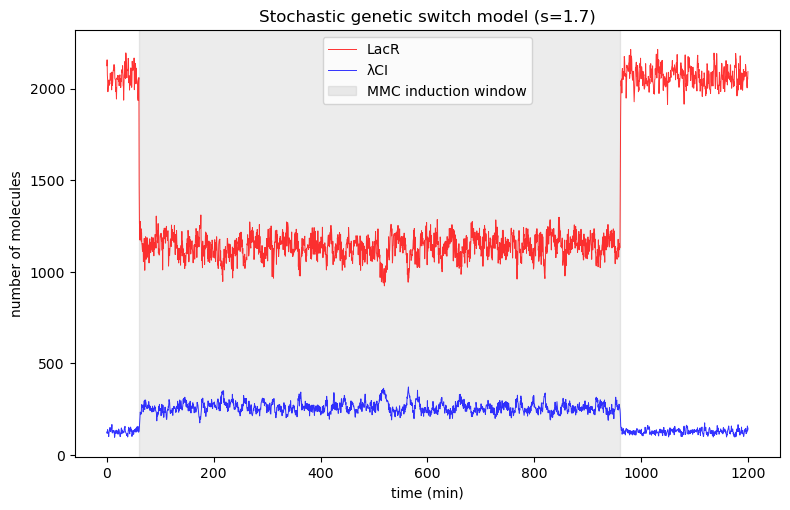

Simulation 2
The system has switched:
	last 200 samples averages:
		u=127.4,
		v=2066.9


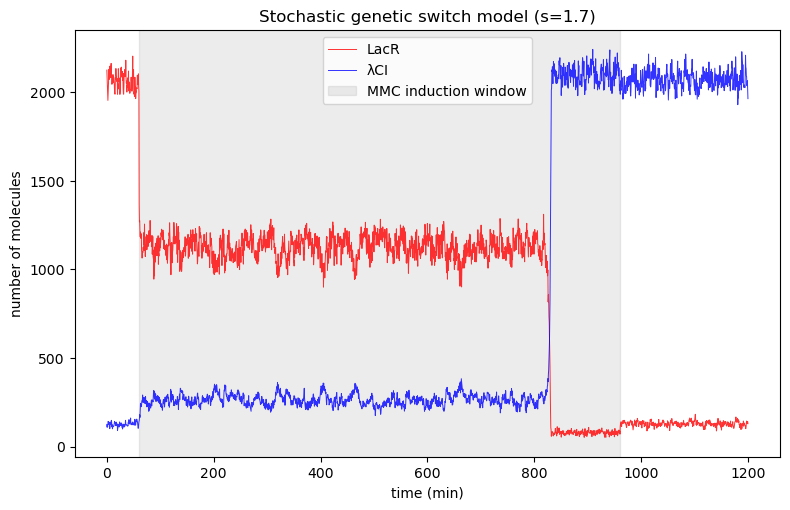

Simulation 3
The system has switched:
	last 200 samples averages:
		u=123.8,
		v=2085.7


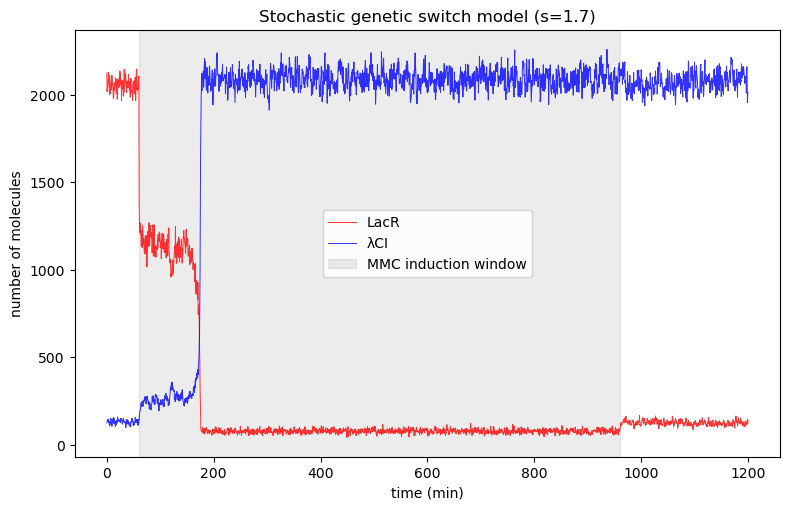

Simulation 4
The system has NOT switched:
	last 200 samples averages:
		u=2062.6,
		v=131.4


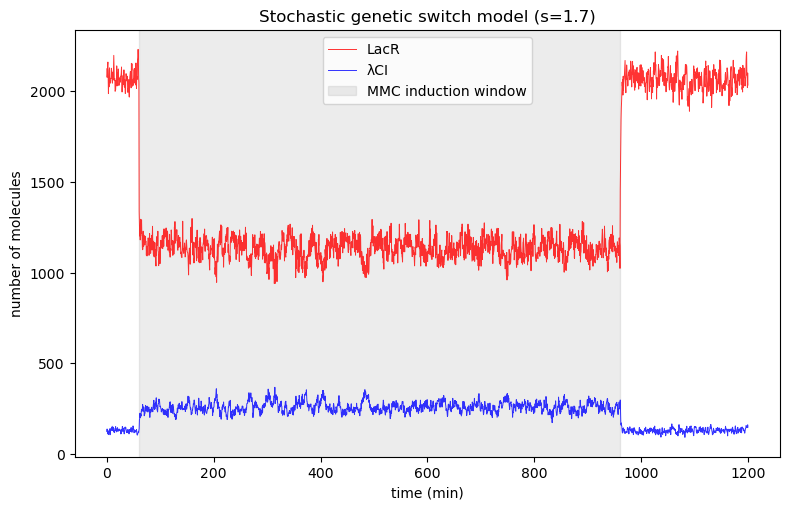

Simulation 5
The system has switched:
	last 200 samples averages:
		u=128.0,
		v=2070.2


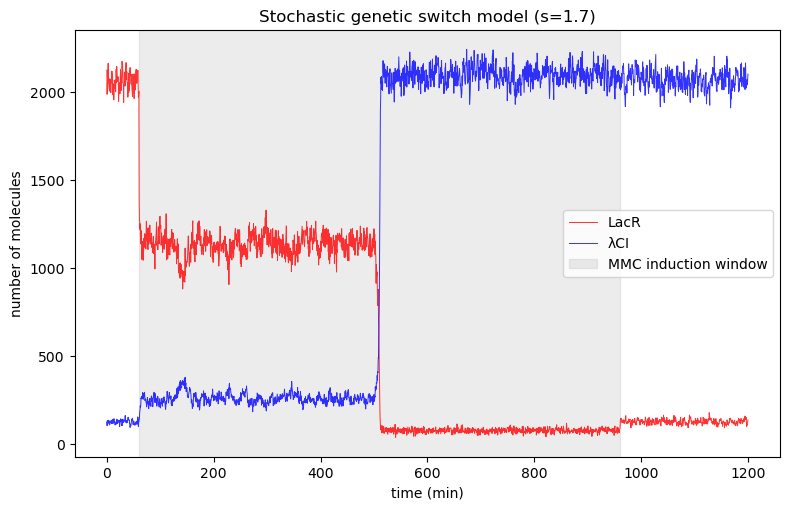

Simulation 6
The system has NOT switched:
	last 200 samples averages:
		u=2070.2,
		v=127.7


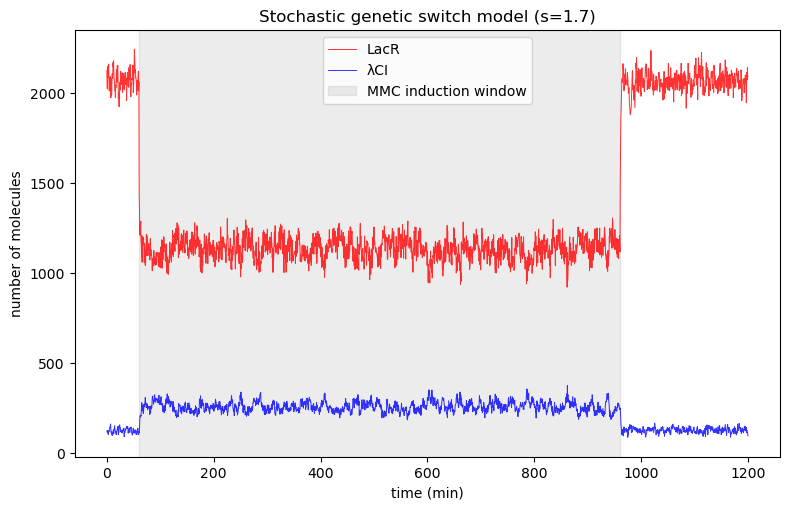

Simulation 7
The system has NOT switched:
	last 200 samples averages:
		u=2056.0,
		v=125.9


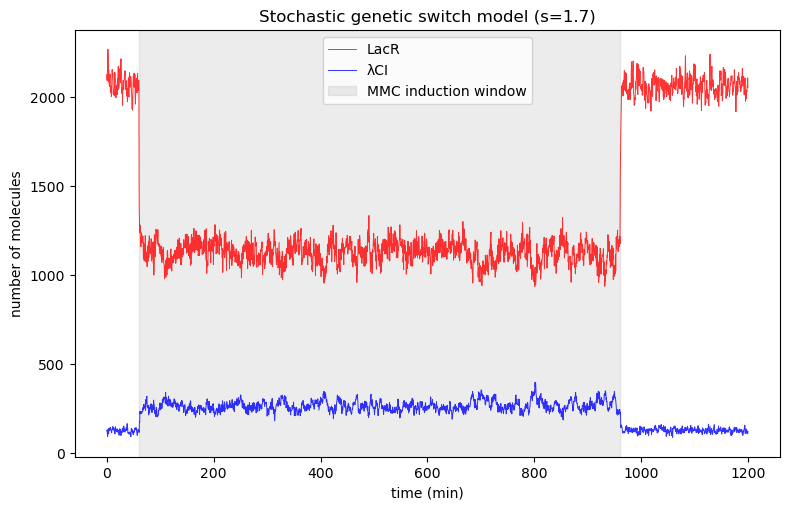

Simulation 8
The system has NOT switched:
	last 200 samples averages:
		u=2073.6,
		v=129.6


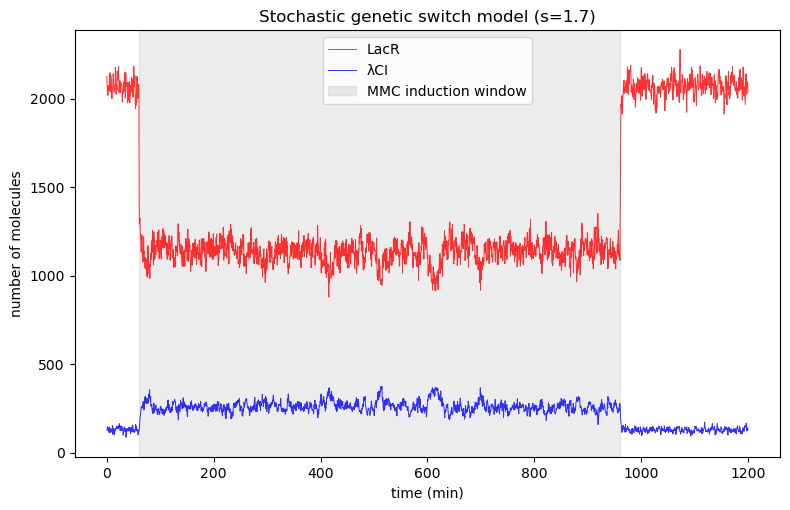

Simulation 9
The system has NOT switched:
	last 200 samples averages:
		u=2075.7,
		v=129.5


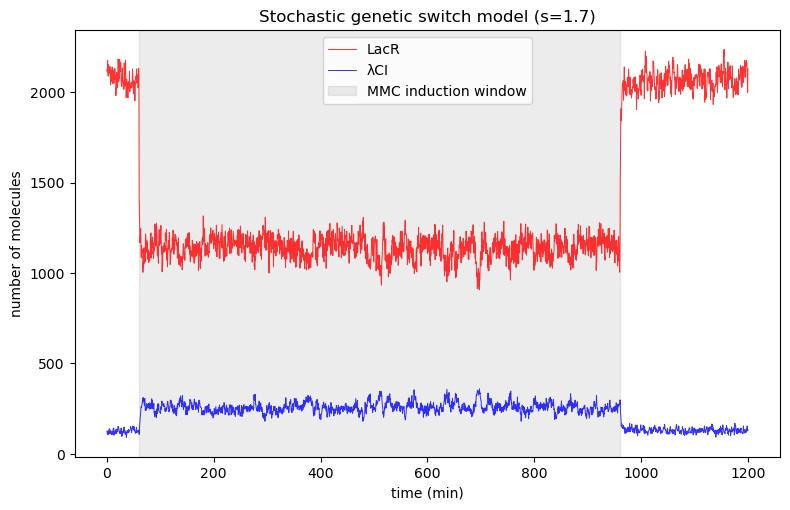

Simulation 10
The system has NOT switched:
	last 200 samples averages:
		u=2061.1,
		v=130.2


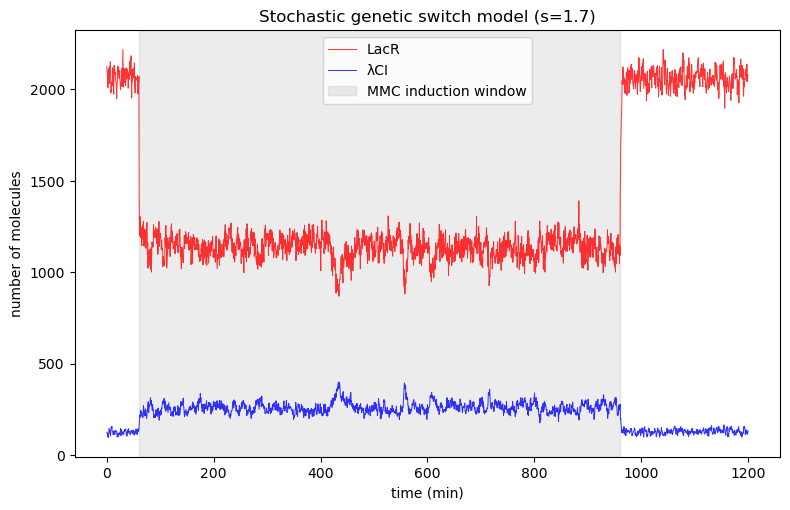

In [126]:
stochastic_model = make_toggle_switch_stochastic(alpha_1, beta_1, alpha_2, beta_2, K1, K2, 
                                                 d1_base, n, d2, gamma, epsilon, u_0_nmolecules, v_0_nmolecules)

# Try a few s values around the reported threshold range
s = 1.7
tau = 0.5

# Running multiple simulations with the same initial conditions and parameters
# to see the variability of the results due to the stochastic nature of the model
N_trials = 10
for i in range(N_trials):
    print(f"Simulation {i+1}")
    sim = stochastic_model(tau, s) 
    check_if_switched(sim, molecules_per_uM, debug_flag=True)
    plot_trajectories([s], [sim], save_plot=False)
    #print("_____________________________________")

Now we try to compute the histogram from Fig.3 of the paper



Running simulations for s=1.3
Running simulations for s=1.7
Running simulations for s=1.75
Running simulations for s=2.0


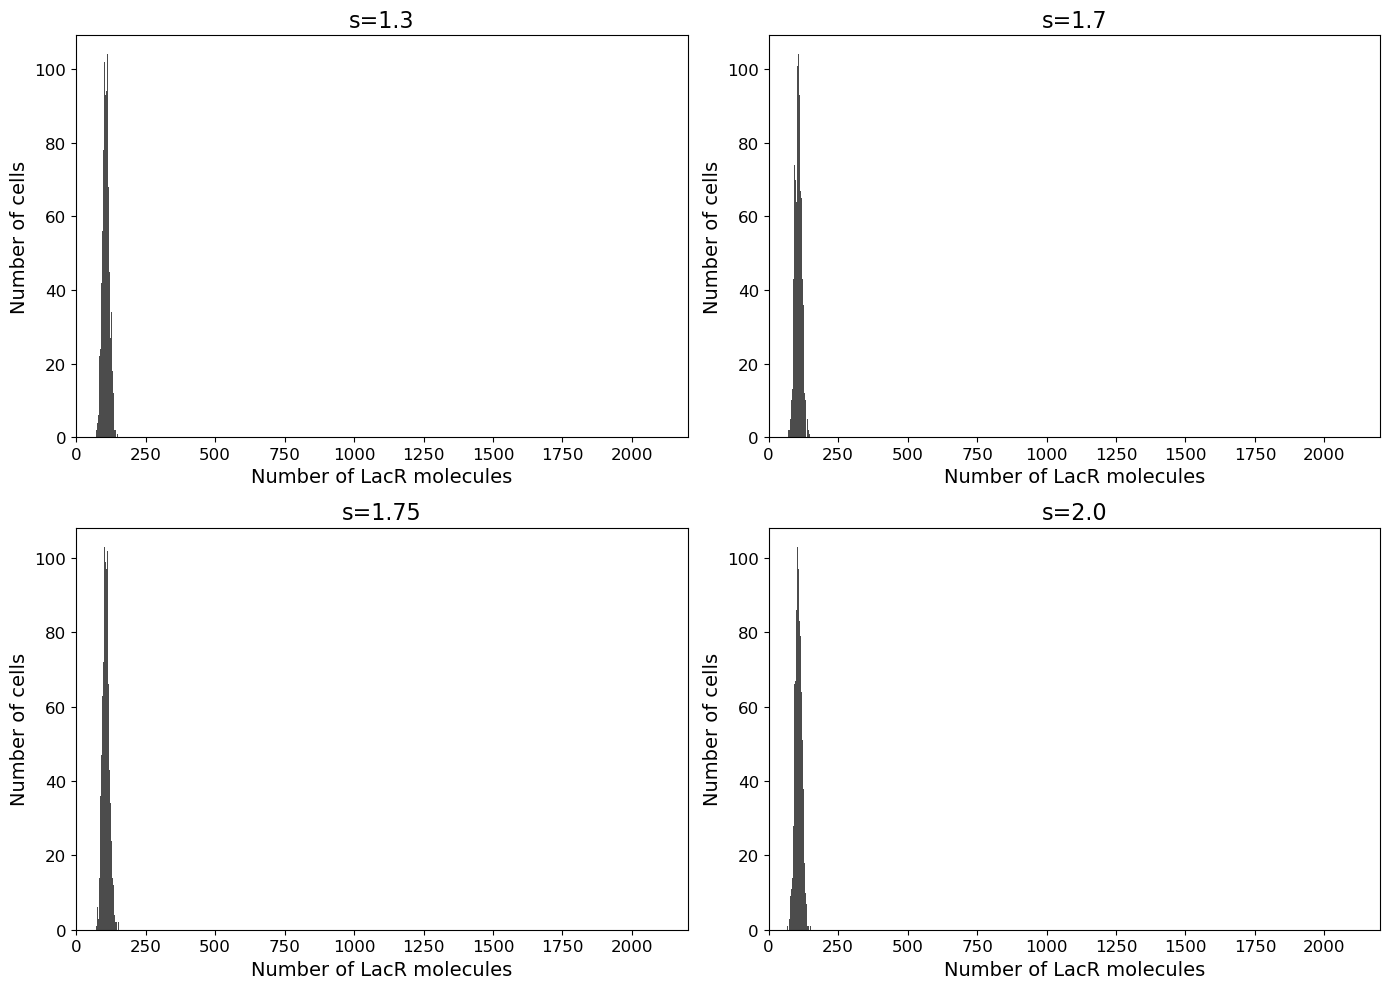

In [163]:
stochastic_model = make_toggle_switch_stochastic(alpha_1, beta_1, alpha_2, beta_2, K1, K2, 
                                                 d1_base, n, d2, gamma, epsilon, u_0_nmolecules, v_0_nmolecules)

s_values = [1.3, 1.7, 1.75, 2.0]
#s_values = [1.7]

N_sims = 1000 # number of simulations to run for each s value

fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2x2 grid
axes = axes.flatten()  # flatten into 1D array for easy indexing

for i, s in enumerate(s_values):
    print(f"Running simulations for s={s}")
    sims = [stochastic_model(tau, s) for _ in range(N_sims)]
    LacR_values = [check_if_switched(sim, molecules_per_uM)[1] for sim in sims]

    binwidth = 3
    axes[i].hist(
        LacR_values,
        bins=range(0, 2200 + binwidth, binwidth),
        color='black', alpha=0.7
    )
    axes[i].set_xlabel("Number of LacR molecules")
    axes[i].set_ylabel("Number of cells")
    axes[i].set_xlim(0, 2200)
    axes[i].set_title(f"s={s}")

plt.tight_layout()
plt.savefig("results/fig3.svg", format="svg")  # save to SVG
plt.show()


<span style="color:red">TODO: sovraimporre la curva sperimentale</span>


#### 3.1) Curva di hill al variare di s (Fig 2d)

In [94]:
stochastic_model = make_toggle_switch_stochastic(alpha_1, beta_1, alpha_2, beta_2, K1, K2, 
                                                 d1_base, n, d2, gamma, epsilon, u_0_nmolecules, v_0_nmolecules)

s_values = np.linspace(1.5,1.85, 15)

N_sims = 1000 # number of simulations to run for each s value

percentages_switched_systems = []
for s in s_values:
    print(f"Running simulations for s={s}")
    sims = [stochastic_model(tau, s) for _ in range(N_sims)]
    switched_systems = sum([check_if_switched(sim, molecules_per_uM)[0] for sim in sims]) 
    
    percentage_switched = (switched_systems / N_sims) * 100
    percentages_switched_systems.append(percentage_switched)
    print(f"\tPercentage of switched systems for s={s}: {percentage_switched:.2f}%")
    print()

#Store results in a file
results_df = pd.DataFrame({
    's': s_values,
    'percentage_switched': percentages_switched_systems
})
results_df.to_csv('fig2d_results.csv', index=False)



Running simulations for s=1.5
Percentage of switched systems for s=1.5: 1.10%
Running simulations for s=1.525
Percentage of switched systems for s=1.525: 1.10%
Running simulations for s=1.55
Percentage of switched systems for s=1.55: 3.10%
Running simulations for s=1.575
Percentage of switched systems for s=1.575: 4.70%
Running simulations for s=1.6
Percentage of switched systems for s=1.6: 7.70%
Running simulations for s=1.625
Percentage of switched systems for s=1.625: 13.30%
Running simulations for s=1.65
Percentage of switched systems for s=1.65: 22.30%
Running simulations for s=1.675
Percentage of switched systems for s=1.675: 34.10%
Running simulations for s=1.7
Percentage of switched systems for s=1.7: 44.20%
Running simulations for s=1.725
Percentage of switched systems for s=1.725: 62.00%
Running simulations for s=1.75
Percentage of switched systems for s=1.75: 77.50%
Running simulations for s=1.7750000000000001
Percentage of switched systems for s=1.7750000000000001: 86.20%
R

In [145]:
results_df


,s,percentage_switched
0,1.500,1.1
1,1.525,1.1
2,1.550,3.1
3,1.575,4.7
4,1.600,7.7
5,1.625,13.3
6,1.650,22.3
7,1.675,34.1
8,1.700,44.2
9,1.725,62.0


Fit base: A=1.1979, B=0.2285, s0=1.4918, n=4
Scaled A to hit p(s_ref=1.850)=99.40% -> A=1.1979


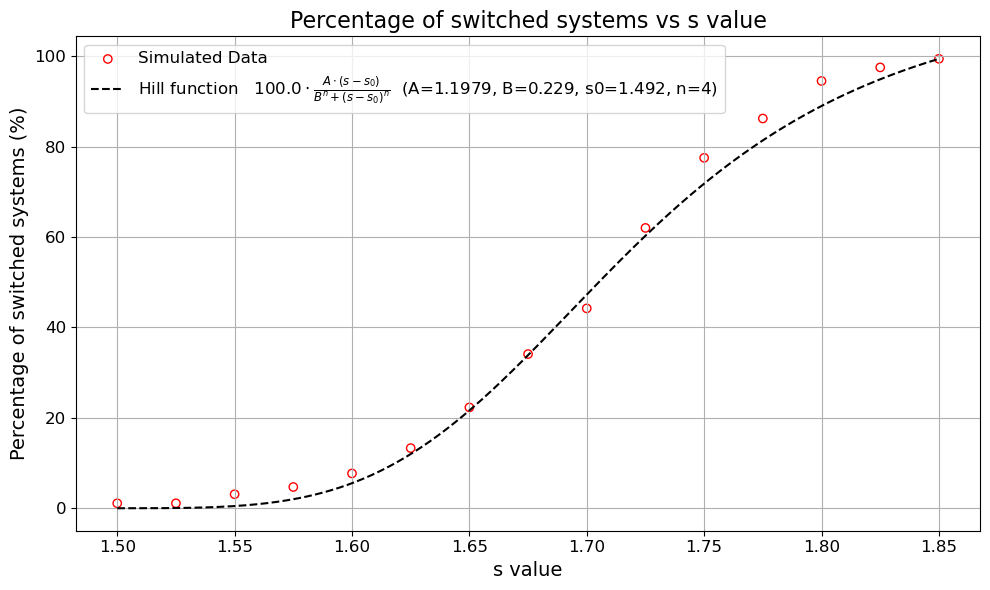

In [ ]:
#### RETRIEVING DATA ####

# Load the data from the CSV file
data = pd.read_csv('fig2d_results.csv')
s_values = data['s'].values
percentages_switched_systems = data['percentage_switched'].values

# Convert data to a numpy array for curve fitting
s = np.asarray(s_values, dtype=float)
p_obs = np.asarray(percentages_switched_systems, dtype=float)


#### FITTING DATA ####

# Fix n=4 (as paper) 
n = 4

def hill_function_base(s, A, B, s0):

    x = s - s0   # ensure x>=0

    return 100.0 * A * (x**n) / (B**n + x**n + 1e-8)

# initial guesses
A_guess = 1.0
B_guess  = 0.25
s0_guess = 1.5
p0  = [A_guess, B_guess, s0_guess]


# bounds: B>0; s<1.5, A>0
bounds = ([1e-9, 1e-9, 1e-9], [10, 1e3, s.min()]) #([lower bounds], [upper bounds])

pars, cov = curve_fit(hill_function_base, s, p_obs, p0=p0, bounds=bounds)
A_fit, B_fit, s0_fit = pars
print(f"Fit base: A={A_fit:.4f}, B={B_fit:.4f}, s0={s0_fit:.4f}, n={n}")


#### RESCALING FIT FUNCTION ####

# compute A to match the last point simulated 
# retrieve the last point
idx_ref = int(np.argmax(p_obs))
s_ref = float(s[idx_ref])
p_target = float(p_obs[idx_ref])    

# Rescale A to match the target percentage at s_ref
x_ref = max(s_ref - s0_fit, 0.0)
hill_base_at_ref = 100.0 * (x_ref**n) / (B_fit**n + x_ref**n + 1e-12)
A_rescale = p_target / (hill_base_at_ref + 1e-12)

print(f"Scaled A to hit p(s_ref={s_ref:.3f})={p_target:.2f}% -> A={A_fit:.4f}")


#### PLOTTING FITTED DATA ####
def hill_function_final(s, A, B, s0):
    x = np.clip(s - s0, 0.0, None)
    return 100.0 * A * (x**n) / (B**n + x**n + 1e-12)


plt.figure(figsize=(10, 6))

plt.scatter(s, p_obs, marker='o', color='red', facecolors='none', label='Simulated Data')

s_grid = np.linspace(s.min(), s.max(), 400)
plt.plot(s_grid, hill_function_final(s_grid, A_rescale, B_fit, s0_fit),
         label=r'Hill function   $100.0\cdot\frac{ A \cdot (s-s_0)}{B^n + (s-s_0)^n}$' + f'  (A={A_fit:.4f}, B={B_fit:.3f}, s0={s0_fit:.3f}, n={n})',
         linestyle='--', color='black')

plt.xlabel('s value')
plt.ylabel('Percentage of switched systems (%)')
plt.title('Percentage of switched systems vs s value')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('results/fig2d_results.svg', format='svg')
plt.show()

